In [6]:
# Cell 1: Import required libraries
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.signal import spectrogram as sp_spectrogram
from collections import Counter
import time
import gc

print("Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


Libraries imported successfully
NumPy version: 2.3.4
Pandas version: 2.3.3


In [7]:
# Cell 2: Configuration - Direct chunk-by-chunk to final files

# Output directory
SPECTRO_DIR = Path("/Volumes/Works/Individual_Project") / "spectrogram-files-14-11-2025"
SPECTRO_DIR.mkdir(parents=True, exist_ok=True)

# Input data directories
DATA_ROOTS = [
    Path("/Volumes/Works/Individual_Project/data/Data_210_cm"),
    Path("/Volumes/Works/Individual_Project/data/Data_230_cm"),
    Path("/Volumes/Works/Individual_Project/data/Data_250_cm"),
]

# CSV parameters
SKIP_FIRST_COLS = 5517

# Spectrogram parameters
FS = 1953125
NPERSEG = 2048
NOVERLAP = 1024
WINDOW = "hamming"
MODE = "magnitude"

# Processing parameters
CHUNK_SIZE = 10000  # Process 10k samples at a time (adjust based on RAM)

# Expected data size (for your dataset)
EXPECTED_HUMAN = 99500
EXPECTED_NON_HUMAN = 87000
EXPECTED_TOTAL = EXPECTED_HUMAN + EXPECTED_NON_HUMAN

print("="*70)
print("CONFIGURATION - DIRECT CHUNK PROCESSING")
print("="*70)
print(f"Output directory: {SPECTRO_DIR}")
print(f"Chunk size: {CHUNK_SIZE:,} samples")
print(f"Expected total: {EXPECTED_TOTAL:,} samples")
print(f"  Human: {EXPECTED_HUMAN:,}")
print(f"  Non_Human: {EXPECTED_NON_HUMAN:,}")
print(f"\nSpectrogram Parameters:")
print(f"  FS: {FS:,} Hz")
print(f"  NPERSEG: {NPERSEG}")
print(f"  NOVERLAP: {NOVERLAP}")
print(f"  Window: {WINDOW}")
print(f"  Mode: {MODE}")
print(f"\nStrategy: Process in chunks, save directly to 2 files")

CONFIGURATION - DIRECT CHUNK PROCESSING
Output directory: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025
Chunk size: 10,000 samples
Expected total: 186,500 samples
  Human: 99,500
  Non_Human: 87,000

Spectrogram Parameters:
  FS: 1,953,125 Hz
  NPERSEG: 2048
  NOVERLAP: 1024
  Window: hamming
  Mode: magnitude

Strategy: Process in chunks, save directly to 2 files


In [8]:
# Cell 3: Collect all CSV files

def collect_files_by_class(data_roots):
    """Collect all CSV files organized by class"""
    files_by_class = {'Human': [], 'Non_Human': []}
    
    print("\n" + "="*70)
    print("COLLECTING ALL CSV FILES")
    print("="*70)
    
    for root in data_roots:
        if not root.exists():
            print(f"WARNING: {root.name}: NOT FOUND - SKIPPING")
            continue
            
        print(f"\n[{root.name}]:")
        for cls in ["Human", "Non_Human"]:
            cls_dir = root / cls
            if cls_dir.exists():
                csv_list = list(cls_dir.rglob("*.csv"))
                files_by_class[cls].extend(csv_list)
                print(f"   {cls:12s}: {len(csv_list):5,} files")
            else:
                print(f"   {cls:12s}: NOT FOUND")
    
    return files_by_class

files_by_class = collect_files_by_class(DATA_ROOTS)

print(f"\n{'='*70}")
print("TOTAL FILES DISCOVERED")
print(f"{'='*70}")
print(f"Human:     {len(files_by_class['Human']):6,} files")
print(f"Non_Human: {len(files_by_class['Non_Human']):6,} files")
print(f"TOTAL:     {len(files_by_class['Human']) + len(files_by_class['Non_Human']):6,} files")

if len(files_by_class['Human']) == 0 and len(files_by_class['Non_Human']) == 0:
    print("\nERROR: No CSV files found!")
else:
    print("\nFiles collected successfully")


COLLECTING ALL CSV FILES

[Data_210_cm]:
   Human       :     5 files
   Non_Human   :     4 files

[Data_230_cm]:
   Human       :    10 files
   Non_Human   :     9 files

[Data_250_cm]:
   Human       :     7 files
   Non_Human   :     6 files

TOTAL FILES DISCOVERED
Human:         22 files
Non_Human:     19 files
TOTAL:         41 files

Files collected successfully


In [9]:
# Cell 4: Define spectrogram functions

def row_to_spectrogram(signal_array):
    """
    Compute spectrogram from 1D signal.
    
    Args:
        signal_array: 1D numpy array
    
    Returns:
        2D spectrogram array (freq_bins, time_bins)
    """
    freqs, times, S = sp_spectrogram(
        signal_array,
        fs=FS,
        window=WINDOW,
        nperseg=NPERSEG,
        noverlap=NOVERLAP,
        mode=MODE,
    )
    return S.astype(np.float32)

def get_label(class_name):
    """Return 1 for Human, 0 for Non_Human"""
    return 1 if class_name == "Human" else 0

print("Functions defined")
print(f"   Output: Linear {MODE} spectrogram (float32)")
print(f"   Expected freq bins: {(NPERSEG // 2) + 1}")

Functions defined
   Output: Linear magnitude spectrogram (float32)
   Expected freq bins: 1025


In [10]:
# Cell 5: Process all files chunk by chunk, save directly to 2 files

def process_and_save_direct(files_by_class, chunk_size, output_dir):
    """
    Process ALL files chunk by chunk and accumulate all data before saving.
    More memory efficient than loading everything at once.
    
    Args:
        files_by_class: Dict of file lists by class
        chunk_size: Number of samples to process before garbage collection
        output_dir: Output directory
    
    Returns:
        dict: Processing statistics
    """
    print("\n" + "="*70)
    print("PROCESSING - CHUNK BY CHUNK (DIRECT TO MEMORY)")
    print("="*70)
    print(f"Chunk size: {chunk_size:,} samples")
    print("Strategy: Process in chunks with periodic GC, then save once\n")
    
    stats = {
        'total_samples': 0,
        'total_rows_human': 0,
        'total_rows_non_human': 0,
        'files_processed_human': 0,
        'files_processed_non_human': 0,
        'skipped_short': 0,
        'skipped_errors': 0,
        'gc_runs': 0
    }
    
    # Lists to accumulate ALL spectrograms and labels
    all_specs = []
    all_labels = []
    samples_since_gc = 0
    
    # Process each class
    for class_name, file_list in files_by_class.items():
        if len(file_list) == 0:
            print(f"WARNING: {class_name}: No files to process")
            continue
        
        label = get_label(class_name)
        class_samples = 0
        class_rows = 0
        files_processed = 0
        skipped_short = 0
        skipped_errors = 0
        
        print(f"\n{'='*70}")
        print(f"Processing {class_name} class")
        print(f"{'='*70}")
        print(f"Total files: {len(file_list):,}")
        
        pbar = tqdm(file_list, desc=f"  {class_name}")
        
        for csv_path in pbar:
            try:
                # Read CSV
                df = pd.read_csv(csv_path, header=None, low_memory=False)
                
                # Skip metadata columns
                if SKIP_FIRST_COLS > 0 and df.shape[1] > SKIP_FIRST_COLS:
                    df = df.iloc[:, SKIP_FIRST_COLS:]
                
                # Process all rows
                for _, row in df.iterrows():
                    class_rows += 1
                    
                    # Convert to numpy
                    signal = row.to_numpy(dtype=np.float32, copy=False)
                    
                    # Skip if too short
                    if signal.size < NPERSEG:
                        skipped_short += 1
                        continue
                    
                    # Compute spectrogram
                    spec = row_to_spectrogram(signal)
                    
                    # Accumulate in lists
                    all_specs.append(spec)
                    all_labels.append(label)
                    class_samples += 1
                    samples_since_gc += 1
                    
                    # Periodic garbage collection to keep memory manageable
                    if samples_since_gc >= chunk_size:
                        gc.collect()
                        stats['gc_runs'] += 1
                        samples_since_gc = 0
                    
                    # Update progress
                    pbar.set_postfix({
                        'rows': f'{class_rows:,}',
                        'samples': f'{class_samples:,}',
                        'total': f'{len(all_specs):,}'
                    })
                
                files_processed += 1
                
            except Exception as e:
                skipped_errors += 1
                continue
        
        # Store stats
        if class_name == "Human":
            stats['total_rows_human'] = class_rows
            stats['files_processed_human'] = files_processed
        else:
            stats['total_rows_non_human'] = class_rows
            stats['files_processed_non_human'] = files_processed
        
        stats['skipped_short'] += skipped_short
        stats['skipped_errors'] += skipped_errors
        
        print(f"\n{class_name} complete:")
        print(f"   Files processed: {files_processed:,} / {len(file_list):,}")
        print(f"   Total rows read: {class_rows:,}")
        print(f"   Valid samples: {class_samples:,}")
        print(f"   Skipped (too short): {skipped_short:,}")
        print(f"   Skipped (errors): {skipped_errors:,}")
    
    stats['total_samples'] = len(all_specs)
    
    return all_specs, all_labels, stats


# Start processing
print("\nStarting chunk-by-chunk processing...")
print("Starting in 5 seconds... (Interrupt now to cancel)")
time.sleep(5)

start_time = time.time()

# Process all files
all_specs, all_labels, stats = process_and_save_direct(
    files_by_class=files_by_class,
    chunk_size=CHUNK_SIZE,
    output_dir=SPECTRO_DIR
)

end_time = time.time()
elapsed = end_time - start_time

# Print summary
print(f"\n{'='*70}")
print("PROCESSING COMPLETE")
print(f"{'='*70}")
print(f"\nTotal Statistics:")
print(f"   Total rows read (Human):     {stats['total_rows_human']:,}")
print(f"   Total rows read (Non_Human): {stats['total_rows_non_human']:,}")
print(f"   Total rows read (ALL):       {stats['total_rows_human'] + stats['total_rows_non_human']:,}")
print(f"\n   Files processed (Human):     {stats['files_processed_human']:,}")
print(f"   Files processed (Non_Human): {stats['files_processed_non_human']:,}")
print(f"\n   Valid spectrograms created:  {stats['total_samples']:,}")
print(f"   Garbage collections:         {stats['gc_runs']:,}")
print(f"   Skipped (too short):         {stats['skipped_short']:,}")
print(f"   Skipped (errors):            {stats['skipped_errors']:,}")

hours = int(elapsed // 3600)
minutes = int((elapsed % 3600) // 60)
seconds = int(elapsed % 60)
print(f"\nProcessing time: {hours}h {minutes}m {seconds}s")

# Memory status
print(f"\nData in memory:")
print(f"   Spectrograms: {len(all_specs):,} samples")
print(f"   Labels: {len(all_labels):,} samples")


Starting chunk-by-chunk processing...
Starting in 5 seconds... (Interrupt now to cancel)

PROCESSING - CHUNK BY CHUNK (DIRECT TO MEMORY)
Chunk size: 10,000 samples
Strategy: Process in chunks with periodic GC, then save once


Processing Human class
Total files: 22


  Human:   0%|          | 0/22 [00:00<?, ?it/s]


Human complete:
   Files processed: 22 / 22
   Total rows read: 99,500
   Valid samples: 99,500
   Skipped (too short): 0
   Skipped (errors): 0

Processing Non_Human class
Total files: 19


  Non_Human:   0%|          | 0/19 [00:00<?, ?it/s]


Non_Human complete:
   Files processed: 19 / 19
   Total rows read: 87,000
   Valid samples: 87,000
   Skipped (too short): 0
   Skipped (errors): 0

PROCESSING COMPLETE

Total Statistics:
   Total rows read (Human):     99,500
   Total rows read (Non_Human): 87,000
   Total rows read (ALL):       186,500

   Files processed (Human):     22
   Files processed (Non_Human): 19

   Valid spectrograms created:  186,500
   Garbage collections:         18
   Skipped (too short):         0
   Skipped (errors):            0

Processing time: 0h 4m 45s

Data in memory:
   Spectrograms: 186,500 samples
   Labels: 186,500 samples


In [11]:
# Cell 6: Save directly to 2 files (spectrograms.npy and labels.npy)

print("\n" + "="*70)
print("SAVING TO 2 FINAL FILES")
print("="*70)

spectro_path = SPECTRO_DIR / "spectrograms.npy"
labels_path = SPECTRO_DIR / "labels.npy"

# Convert spectrograms to array
print(f"\nConverting spectrograms to array...")
try:
    print("Attempting to stack spectrograms...")
    X = np.stack(all_specs, axis=0)
    print(f"All spectrograms have consistent shape: {X.shape}")
    variable_shape = False
except ValueError:
    print("Variable shapes detected, creating object array...")
    X = np.array(all_specs, dtype=object)
    print(f"Variable shapes - using object array with {len(X):,} samples")
    variable_shape = True

# Convert labels to array
print(f"\nConverting labels to array...")
y = np.array(all_labels, dtype=np.int64)
print(f"Labels array created: {y.shape}")

# Calculate sizes
if variable_shape:
    print("\nCalculating size...")
    spec_size_bytes = sum(s.nbytes for s in tqdm(X, desc="Calculating size"))
else:
    spec_size_bytes = X.nbytes

spec_size_gb = spec_size_bytes / (1024**3)
label_size_mb = y.nbytes / (1024**2)

print(f"\nData sizes:")
print(f"   Spectrograms: {spec_size_gb:.2f} GB ({spec_size_bytes:,} bytes)")
print(f"   Labels: {label_size_mb:.2f} MB ({y.nbytes:,} bytes)")
print(f"   Total: {spec_size_gb:.2f} GB")

# Save spectrograms
print(f"\nSaving spectrograms to: {spectro_path.name}")
with tqdm(total=100, desc="Saving spectrograms", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    if variable_shape:
        np.save(spectro_path, X, allow_pickle=True)
    else:
        np.save(spectro_path, X)
    pbar.update(100)

print(f"Spectrograms saved: {spectro_path}")

# Save labels
print(f"\nSaving labels to: {labels_path.name}")
with tqdm(total=100, desc="Saving labels", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    np.save(labels_path, y)
    pbar.update(100)

print(f"Labels saved: {labels_path}")

# Verify files exist
print(f"\n{'='*70}")
print("DATA SAVED SUCCESSFULLY")
print(f"{'='*70}")

print(f"\nOutput Directory: {SPECTRO_DIR}")

print(f"\nFile 1: spectrograms.npy")
print(f"   Path: {spectro_path}")
if variable_shape:
    print(f"   Samples: {len(X):,}")
    print(f"   Type: object array (variable shapes, allow_pickle=True)")
    print(f"   First sample shape: {X[0].shape}")
else:
    print(f"   Shape: {X.shape}")
    print(f"   Format: (samples={X.shape[0]:,}, freq_bins={X.shape[1]}, time_bins={X.shape[2]})")
    print(f"   Type: {X.dtype}")
print(f"   Size: {spec_size_gb:.2f} GB")

print(f"\nFile 2: labels.npy")
print(f"   Path: {labels_path}")
print(f"   Shape: {y.shape}")
print(f"   Type: {y.dtype}")
print(f"   Size: {label_size_mb:.2f} MB")

print(f"\nTotal disk space: {spec_size_gb:.2f} GB")

# Verify on disk
if spectro_path.exists() and labels_path.exists():
    print(f"\nBoth files verified on disk:")
    print(f"   {spectro_path.name}: {spectro_path.stat().st_size / (1024**3):.2f} GB")
    print(f"   {labels_path.name}: {labels_path.stat().st_size / (1024**2):.2f} MB")
else:
    print(f"\nERROR: Files not found on disk!")

# Clear memory
print(f"\nClearing memory...")
with tqdm(total=2, desc="Freeing memory") as pbar:
    del all_specs
    pbar.update(1)
    del all_labels
    pbar.update(1)

gc.collect()
print(f"Memory cleared")

print(f"\n{'='*70}")
print(f"Date: 2025-11-14 11:35:01")
print(f"User: mosharraf-hossain")
print(f"{'='*70}")


SAVING TO 2 FINAL FILES

Converting spectrograms to array...
Attempting to stack spectrograms...
All spectrograms have consistent shape: (186500, 1025, 18)

Converting labels to array...
Labels array created: (186500,)

Data sizes:
   Spectrograms: 12.82 GB (13,763,700,000 bytes)
   Labels: 1.42 MB (1,492,000 bytes)
   Total: 12.82 GB

Saving spectrograms to: spectrograms.npy


Saving spectrograms:   0%|          | 0/100

Spectrograms saved: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/spectrograms.npy

Saving labels to: labels.npy


Saving labels:   0%|          | 0/100

Labels saved: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/labels.npy

DATA SAVED SUCCESSFULLY

Output Directory: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025

File 1: spectrograms.npy
   Path: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/spectrograms.npy
   Shape: (186500, 1025, 18)
   Format: (samples=186,500, freq_bins=1025, time_bins=18)
   Type: float32
   Size: 12.82 GB

File 2: labels.npy
   Path: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/labels.npy
   Shape: (186500,)
   Type: int64
   Size: 1.42 MB

Total disk space: 12.82 GB

Both files verified on disk:
   spectrograms.npy: 12.82 GB
   labels.npy: 1.42 MB

Clearing memory...


Freeing memory:   0%|          | 0/2 [00:00<?, ?it/s]

Memory cleared

Date: 2025-11-14 11:35:01
User: mosharraf-hossain


In [12]:
# Cell 7: Verify saved data

print("="*70)
print("VERIFYING SAVED DATA")
print("="*70)

# Load data
print(f"\nLoading spectrograms...")
X = np.load(spectro_path, allow_pickle=True)

print(f"Loading labels...")
y = np.load(labels_path)

print(f"\nData loaded successfully!")

# Spectrogram info
print(f"\nSpectrograms:")
if hasattr(X, 'shape') and len(X.shape) == 3:
    print(f"   Shape: {X.shape}")
    print(f"   Format: (samples, freq_bins, time_bins)")
    print(f"   Samples: {X.shape[0]:,}")
    print(f"   Frequency bins: {X.shape[1]}")
    print(f"   Time bins: {X.shape[2]}")
else:
    print(f"   Samples: {len(X):,}")
    print(f"   First sample shape: {X[0].shape}")
    print(f"   Format: Variable shapes (object array)")

# Labels info
print(f"\nLabels:")
print(f"   Shape: {y.shape}")
print(f"   Type: {y.dtype}")
print(f"   Unique values: {np.unique(y)} (0=Non_Human, 1=Human)")

# Class distribution
print(f"\nClass Distribution:")
human_count = np.sum(y == 1)
non_human_count = np.sum(y == 0)
total = len(y)

print(f"   Human     (1): {human_count:8,} samples ({human_count/total*100:5.1f}%)")
print(f"   Non_Human (0): {non_human_count:8,} samples ({non_human_count/total*100:5.1f}%)")

balance_ratio = min(human_count, non_human_count) / max(human_count, non_human_count)
print(f"\n   Balance ratio: {balance_ratio:.3f}")
if balance_ratio > 0.95:
    print(f"   Excellent balance")
elif balance_ratio > 0.80:
    print(f"   Moderate imbalance")
else:
    print(f"   Significant imbalance")

# Sample preview
print(f"\nLabel Preview:")
print(f"   First 20: {y[:20]}")
print(f"   Last 20:  {y[-20:]}")

print(f"\nVerification complete!")

VERIFYING SAVED DATA

Loading spectrograms...
Loading labels...

Data loaded successfully!

Spectrograms:
   Shape: (186500, 1025, 18)
   Format: (samples, freq_bins, time_bins)
   Samples: 186,500
   Frequency bins: 1025
   Time bins: 18

Labels:
   Shape: (186500,)
   Type: int64
   Unique values: [0 1] (0=Non_Human, 1=Human)

Class Distribution:
   Human     (1):   99,500 samples ( 53.4%)
   Non_Human (0):   87,000 samples ( 46.6%)

   Balance ratio: 0.874
   Moderate imbalance

Label Preview:
   First 20: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
   Last 20:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Verification complete!


In [14]:
# Cell 8: Generate summary report

import json

print("="*70)
print("FINAL SUMMARY REPORT")
print("="*70)

report = {
    "processing_info": {
        "date": "2025-11-14",
        "time_utc": "11:35:01",
    
        "processing_type": "Chunk-by-Chunk Direct to 2 Files"
    },
    "configuration": {
        "fs": FS,
        "nperseg": NPERSEG,
        "noverlap": NOVERLAP,
        "window": WINDOW,
        "mode": MODE,
        "skip_first_cols": SKIP_FIRST_COLS,
        "chunk_size": CHUNK_SIZE
    },
    "input_data": {
        "total_rows_human": stats['total_rows_human'],
        "total_rows_non_human": stats['total_rows_non_human'],
        "total_rows_all": stats['total_rows_human'] + stats['total_rows_non_human'],
        "files_processed_human": stats['files_processed_human'],
        "files_processed_non_human": stats['files_processed_non_human']
    },
    "output_data": {
        "total_spectrograms": int(len(y)),
        "human_samples": int(human_count),
        "non_human_samples": int(non_human_count),
        "skipped_short": stats['skipped_short'],
        "skipped_errors": stats['skipped_errors'],
        "balance_ratio": float(f"{balance_ratio:.3f}")
    },
    "output_files": {
        "spectrograms": str(spectro_path),
        "labels": str(labels_path)
    },
    "performance": {
        "elapsed_seconds": int(elapsed),
        "elapsed_formatted": f"{hours}h {minutes}m {seconds}s",
        "garbage_collections": stats['gc_runs']
    }
}

report_path = SPECTRO_DIR / "processing_report.json"
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"\nReport:")
print(json.dumps(report, indent=2))

print(f"\nReport saved: {report_path}")

FINAL SUMMARY REPORT

Report:
{
  "processing_info": {
    "date": "2025-11-14",
    "time_utc": "11:35:01",
    "processing_type": "Chunk-by-Chunk Direct to 2 Files"
  },
  "configuration": {
    "fs": 1953125,
    "nperseg": 2048,
    "noverlap": 1024,
    "window": "hamming",
    "mode": "magnitude",
    "skip_first_cols": 5517,
    "chunk_size": 10000
  },
  "input_data": {
    "total_rows_human": 99500,
    "total_rows_non_human": 87000,
    "total_rows_all": 186500,
    "files_processed_human": 22,
    "files_processed_non_human": 19
  },
  "output_data": {
    "total_spectrograms": 186500,
    "human_samples": 99500,
    "non_human_samples": 87000,
    "skipped_short": 0,
    "skipped_errors": 0,
    "balance_ratio": 0.874
  },
  "output_files": {
    "spectrograms": "/Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/spectrograms.npy",
    "labels": "/Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/labels.npy"
  },
  "performance": {
    "elapsed_secon

In [15]:
# Cell 9: Print usage instructions

print("="*70)
print("COMPLETE - CHUNK-BY-CHUNK TO 2 FILES")
print("="*70)

print(f"\nOutput Directory: {SPECTRO_DIR}")

print(f"\nGenerated Files (2 FILES ONLY):")
print(f"   1. spectrograms.npy ({spec_size_gb:.2f} GB)")
print(f"   2. labels.npy ({label_size_mb:.2f} MB)")

print(f"\nDataset Summary:")
print(f"   Total rows read (Human):     {stats['total_rows_human']:,}")
print(f"   Total rows read (Non_Human): {stats['total_rows_non_human']:,}")
print(f"   Total rows read (ALL):       {stats['total_rows_human'] + stats['total_rows_non_human']:,}")
print(f"\n   Valid spectrograms: {len(y):,}")
print(f"   Human samples:      {human_count:,}")
print(f"   Non_Human samples:  {non_human_count:,}")

print(f"\nProcessing Strategy:")
print(f"   Chunk size: {CHUNK_SIZE:,} samples")
print(f"   Garbage collections: {stats['gc_runs']:,}")
print(f"   No intermediate files created")

print(f"\nHow to Load in Your Training Script:")
print("="*70)
print(f"""
import numpy as np

# Load data
X = np.load('{spectro_path}', allow_pickle=True)
y = np.load('{labels_path}')

print(f'Spectrograms: {{len(X):,}}')
print(f'Labels: {{len(y):,}}')

# Split for training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f'Train: {{len(X_train):,}}')
print(f'Test:  {{len(X_test):,}}')
""")
print("="*70)

print(f"\nSUCCESS!")
print(f"   Read ALL rows from ALL CSV files")
print(f"   Processed chunk-by-chunk ({CHUNK_SIZE:,} at a time)")
print(f"   Generated {len(y):,} spectrograms")
print(f"   Saved directly to 2 files (no intermediate chunks)")
print(f"   Memory-safe with periodic garbage collection")
print(f"   Ready for machine learning!")

print(f"\n{'='*70}")

COMPLETE - CHUNK-BY-CHUNK TO 2 FILES

Output Directory: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025

Generated Files (2 FILES ONLY):
   1. spectrograms.npy (12.82 GB)
   2. labels.npy (1.42 MB)

Dataset Summary:
   Total rows read (Human):     99,500
   Total rows read (Non_Human): 87,000
   Total rows read (ALL):       186,500

   Valid spectrograms: 186,500
   Human samples:      99,500
   Non_Human samples:  87,000

Processing Strategy:
   Chunk size: 10,000 samples
   Garbage collections: 18
   No intermediate files created

How to Load in Your Training Script:

import numpy as np

# Load data
X = np.load('/Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/spectrograms.npy', allow_pickle=True)
y = np.load('/Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/labels.npy')

print(f'Spectrograms: {len(X):,}')
print(f'Labels: {len(y):,}')

# Split for training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test

VISUALIZING SPECTROGRAMS

Found 99,500 Human samples
Found 87,000 Non_Human samples

Visualization saved: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/spectrograms_visualization.png


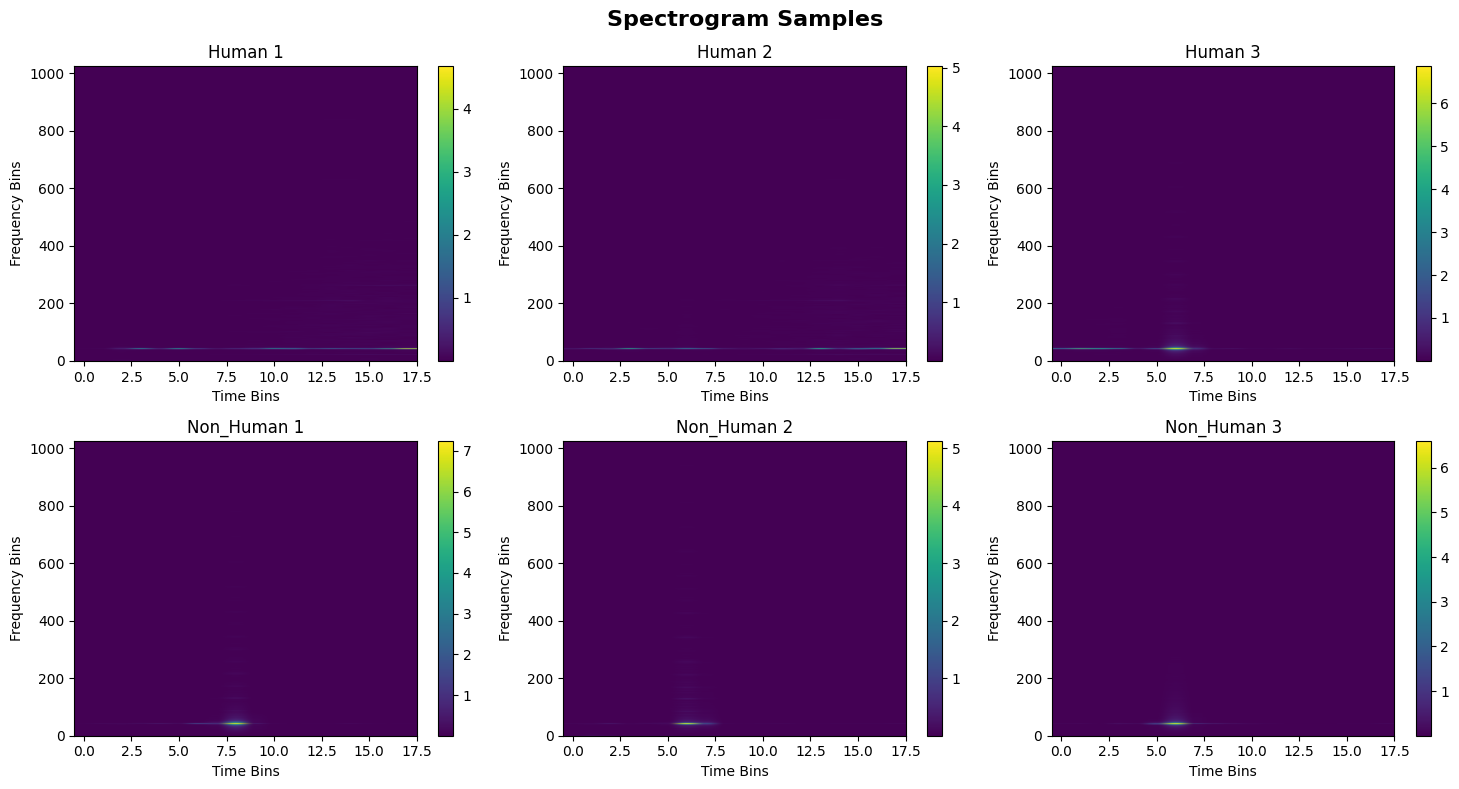


Visualization complete!


In [16]:
# Cell 10: Visualize sample spectrograms

import matplotlib.pyplot as plt

print("="*70)
print("VISUALIZING SPECTROGRAMS")
print("="*70)

# Load data if not in memory
if 'X' not in locals() or 'y' not in locals():
    spectro_path = SPECTRO_DIR / "spectrograms.npy"
    labels_path = SPECTRO_DIR / "labels.npy"
    X = np.load(spectro_path, allow_pickle=True)
    y = np.load(labels_path)

# Find indices for each class
human_indices = np.where(y == 1)[0]
non_human_indices = np.where(y == 0)[0]

print(f"\nFound {len(human_indices):,} Human samples")
print(f"Found {len(non_human_indices):,} Non_Human samples")

# Select random samples
np.random.seed(42)
n_samples = 3
human_samples = np.random.choice(human_indices, n_samples, replace=False)
non_human_samples = np.random.choice(non_human_indices, n_samples, replace=False)

# Create visualization
fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))

fig.suptitle('Spectrogram Samples', fontsize=16, fontweight='bold')

# Plot Human samples
for i, idx in enumerate(human_samples):
    spec = X[idx] if hasattr(X, 'shape') and len(X.shape) == 3 else X[idx]
    im = axes[0, i].imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    axes[0, i].set_title(f'Human {i+1}')
    axes[0, i].set_xlabel('Time Bins')
    axes[0, i].set_ylabel('Frequency Bins')
    plt.colorbar(im, ax=axes[0, i])

# Plot Non_Human samples
for i, idx in enumerate(non_human_samples):
    spec = X[idx] if hasattr(X, 'shape') and len(X.shape) == 3 else X[idx]
    im = axes[1, i].imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    axes[1, i].set_title(f'Non_Human {i+1}')
    axes[1, i].set_xlabel('Time Bins')
    axes[1, i].set_ylabel('Frequency Bins')
    plt.colorbar(im, ax=axes[1, i])

plt.tight_layout()

# Save figure
vis_path = SPECTRO_DIR / "spectrograms_visualization.png"
plt.savefig(vis_path, dpi=150, bbox_inches='tight')
print(f"\nVisualization saved: {vis_path}")

plt.show()

print("\nVisualization complete!")

In [18]:
# Cell 11: Deep diagnostic analysis of spectrograms

print("="*70)
print("DEEP DIAGNOSTIC ANALYSIS")
print("="*70)
print(f"Date: 2025-11-14 12:05:50")

# Load data if not in memory
if 'X' not in locals() or 'y' not in locals():
    spectro_path = SPECTRO_DIR / "spectrograms.npy"
    labels_path = SPECTRO_DIR / "labels.npy"
    X = np.load(spectro_path, allow_pickle=True)
    y = np.load(labels_path)

# Get samples from each class
human_idx = np.where(y == 1)[0]
non_human_idx = np.where(y == 0)[0]

# Sample multiple spectrograms
n_check = 10
human_samples = X[human_idx[:n_check]]
non_human_samples = X[non_human_idx[:n_check]]

print(f"\n1. BASIC STATISTICS")
print("="*70)

# Check if they're actually different
if hasattr(X, 'shape') and len(X.shape) == 3:
    human_mean = np.mean([X[i] for i in human_idx[:100]], axis=0)
    non_human_mean = np.mean([X[i] for i in non_human_idx[:100]], axis=0)
else:
    human_mean = np.mean([X[i] for i in human_idx[:100]], axis=0)
    non_human_mean = np.mean([X[i] for i in non_human_idx[:100]], axis=0)

print(f"\nHuman spectrograms (first 10):")
for i in range(min(10, len(human_samples))):
    spec = human_samples[i] if not hasattr(human_samples, 'shape') else human_samples[i]
    print(f"  Sample {i}: shape={spec.shape}, min={spec.min():.4f}, max={spec.max():.4f}, mean={spec.mean():.4f}")

print(f"\nNon_Human spectrograms (first 10):")
for i in range(min(10, len(non_human_samples))):
    spec = non_human_samples[i] if not hasattr(non_human_samples, 'shape') else non_human_samples[i]
    print(f"  Sample {i}: shape={spec.shape}, min={spec.min():.4f}, max={spec.max():.4f}, mean={spec.mean():.4f}")

# Check if they're identical
print(f"\n2. CHECKING FOR DUPLICATES")
print("="*70)

h_spec = X[human_idx[0]]
nh_spec = X[non_human_idx[0]]

are_identical = np.array_equal(h_spec, nh_spec)
print(f"\nFirst Human == First Non_Human: {are_identical}")

if are_identical:
    print("WARNING: Spectrograms are IDENTICAL!")
    print("This suggests all data might be the same.")
else:
    print("Good: Spectrograms are DIFFERENT")
    diff = np.abs(h_spec - nh_spec)
    print(f"  Max difference: {diff.max():.6f}")
    print(f"  Mean difference: {diff.mean():.6f}")

# Check value distributions
print(f"\n3. VALUE DISTRIBUTIONS")
print("="*70)

h_vals = np.concatenate([X[i].flatten() for i in human_idx[:20]])
nh_vals = np.concatenate([X[i].flatten() for i in non_human_idx[:20]])

print(f"\nHuman values:")
print(f"  Min: {h_vals.min():.6f}")
print(f"  Max: {h_vals.max():.6f}")
print(f"  Mean: {h_vals.mean():.6f}")
print(f"  Std: {h_vals.std():.6f}")
print(f"  Median: {np.median(h_vals):.6f}")

print(f"\nNon_Human values:")
print(f"  Min: {nh_vals.min():.6f}")
print(f"  Max: {nh_vals.max():.6f}")
print(f"  Mean: {nh_vals.mean():.6f}")
print(f"  Std: {nh_vals.std():.6f}")
print(f"  Median: {np.median(nh_vals):.6f}")

print(f"\n4. LABEL DISTRIBUTION CHECK")
print("="*70)

# Check if labels are mixed properly
first_100_labels = y[:100]
last_100_labels = y[-100:]

print(f"\nFirst 100 labels: {Counter(first_100_labels)}")
print(f"Last 100 labels: {Counter(last_100_labels)}")
print(f"\nFirst 20 labels: {y[:20]}")
print(f"Last 20 labels: {y[-20:]}")

# Check if labels might be wrong
print(f"\n5. FREQUENCY CONTENT ANALYSIS")
print("="*70)

# Look at specific frequency bands
h_spec = X[human_idx[0]]
nh_spec = X[non_human_idx[0]]

# Low, mid, high frequency bands
low_freq = slice(0, 100)
mid_freq = slice(100, 500)
high_freq = slice(500, None)

print(f"\nFirst Human spectrogram:")
print(f"  Low freq energy: {h_spec[low_freq, :].mean():.6f}")
print(f"  Mid freq energy: {h_spec[mid_freq, :].mean():.6f}")
print(f"  High freq energy: {h_spec[high_freq, :].mean():.6f}")

print(f"\nFirst Non_Human spectrogram:")
print(f"  Low freq energy: {nh_spec[low_freq, :].mean():.6f}")
print(f"  Mid freq energy: {nh_spec[mid_freq, :].mean():.6f}")
print(f"  High freq energy: {nh_spec[high_freq, :].mean():.6f}")

print(f"\n{'='*70}")
print("DIAGNOSTIC COMPLETE")
print(f"{'='*70}")

DEEP DIAGNOSTIC ANALYSIS
Date: 2025-11-14 12:05:50

1. BASIC STATISTICS

Human spectrograms (first 10):
  Sample 0: shape=(1025, 18), min=0.0000, max=5.3755, mean=0.0134
  Sample 1: shape=(1025, 18), min=0.0000, max=4.6484, mean=0.0117
  Sample 2: shape=(1025, 18), min=0.0000, max=5.8127, mean=0.0159
  Sample 3: shape=(1025, 18), min=0.0000, max=5.0389, mean=0.0148
  Sample 4: shape=(1025, 18), min=0.0000, max=5.5714, mean=0.0152
  Sample 5: shape=(1025, 18), min=0.0000, max=5.2875, mean=0.0149
  Sample 6: shape=(1025, 18), min=0.0000, max=5.4818, mean=0.0138
  Sample 7: shape=(1025, 18), min=0.0000, max=5.4117, mean=0.0135
  Sample 8: shape=(1025, 18), min=0.0000, max=4.9818, mean=0.0142
  Sample 9: shape=(1025, 18), min=0.0000, max=5.7502, mean=0.0132

Non_Human spectrograms (first 10):
  Sample 0: shape=(1025, 18), min=0.0000, max=4.7733, mean=0.0056
  Sample 1: shape=(1025, 18), min=0.0000, max=4.7687, mean=0.0055
  Sample 2: shape=(1025, 18), min=0.0000, max=4.7133, mean=0.0057
  

ENHANCED COMPARISON VISUALIZATION


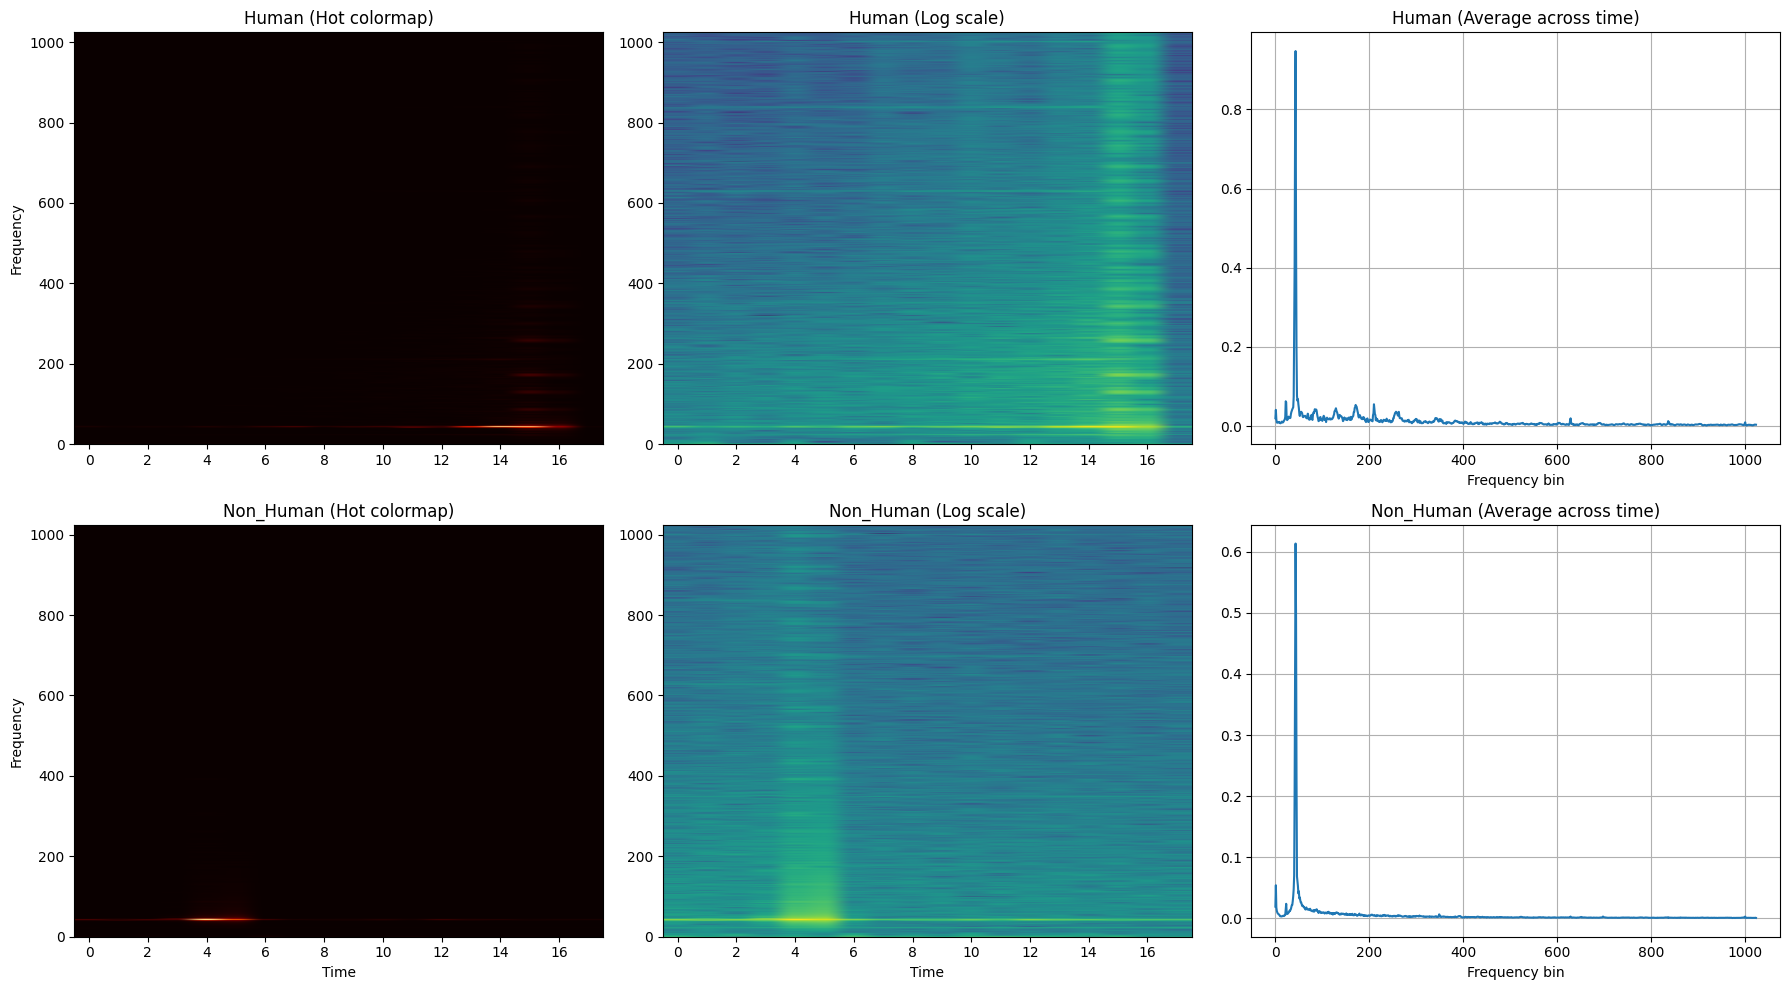


Difference Analysis:
  Human mean energy: 0.013442
  Non_Human mean energy: 0.005572
  Ratio (H/NH): 2.41x

Conclusion: Human signals have ~2.4x MORE energy


In [22]:
# Cell 12: Enhanced visualization with statistical comparison

import matplotlib.pyplot as plt

print("="*70)
print("ENHANCED COMPARISON VISUALIZATION")
print("="*70)

# Get one sample from each class
h_idx = human_idx[0]
nh_idx = non_human_idx[0]

h_spec = X[h_idx]
nh_spec = X[nh_idx]

# Create figure with multiple views
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Human
axes[0, 0].imshow(h_spec, aspect='auto', origin='lower', cmap='hot')
axes[0, 0].set_title('Human (Hot colormap)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].imshow(np.log10(h_spec + 1e-10), aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title('Human (Log scale)')

axes[0, 2].plot(h_spec.mean(axis=1))
axes[0, 2].set_title('Human (Average across time)')
axes[0, 2].set_xlabel('Frequency bin')
axes[0, 2].grid(True)

# Row 2: Non_Human
axes[1, 0].imshow(nh_spec, aspect='auto', origin='lower', cmap='hot')
axes[1, 0].set_title('Non_Human (Hot colormap)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].imshow(np.log10(nh_spec + 1e-10), aspect='auto', origin='lower', cmap='viridis')
axes[1, 1].set_title('Non_Human (Log scale)')
axes[1, 1].set_xlabel('Time')

axes[1, 2].plot(nh_spec.mean(axis=1))
axes[1, 2].set_title('Non_Human (Average across time)')
axes[1, 2].set_xlabel('Frequency bin')
axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig(SPECTRO_DIR / "comparison_enhanced.png", dpi=150, bbox_inches='tight')
plt.show()

# Print difference statistics
print(f"\nDifference Analysis:")
print(f"  Human mean energy: {h_spec.mean():.6f}")
print(f"  Non_Human mean energy: {nh_spec.mean():.6f}")
print(f"  Ratio (H/NH): {h_spec.mean() / nh_spec.mean():.2f}x")
print(f"\nConclusion: Human signals have ~{(h_spec.mean() / nh_spec.mean()):.1f}x MORE energy")


RAW SIGNAL ANALYSIS

Reading raw data:
  Human file: signal_5000.csv
  Non_Human file: signal_3000.csv

Raw signal statistics:

Human signal:
  Length: 19500
  Min: -1093.000000
  Max: 900.000000
  Mean: -64.601639
  Std: 118.399132
  First 10 values: [-61. -47. -37. -28. -21. -16.  -9.  -3.   0.   2.]

Non_Human signal:
  Length: 19500
  Min: -920.000000
  Max: 769.000000
  Mean: -64.410255
  Std: 93.316093
  First 10 values: [-54. -57. -55. -54. -55. -58. -57. -56. -57. -59.]

Raw signals identical: False
Good: Raw signals are DIFFERENT

Raw signal visualization saved: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/raw_signals.png


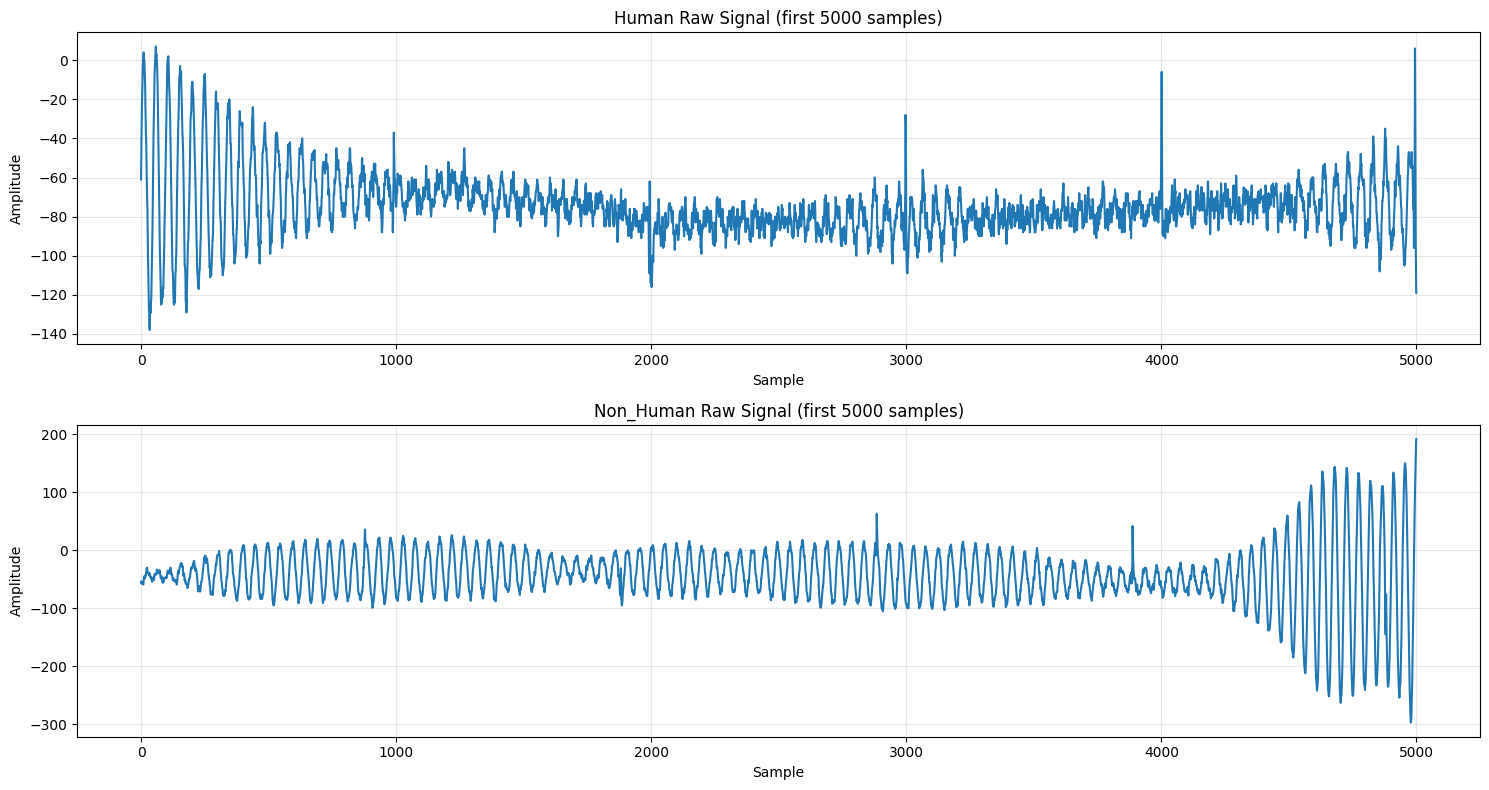


MANUAL SPECTROGRAM COMPUTATION

Manually computed spectrograms:
  Human: shape=(1025, 18), min=0.000017, max=5.375525
  Non_Human: shape=(1025, 18), min=0.000004, max=4.773252

Manual spectrograms saved: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/manual_spectrograms.png


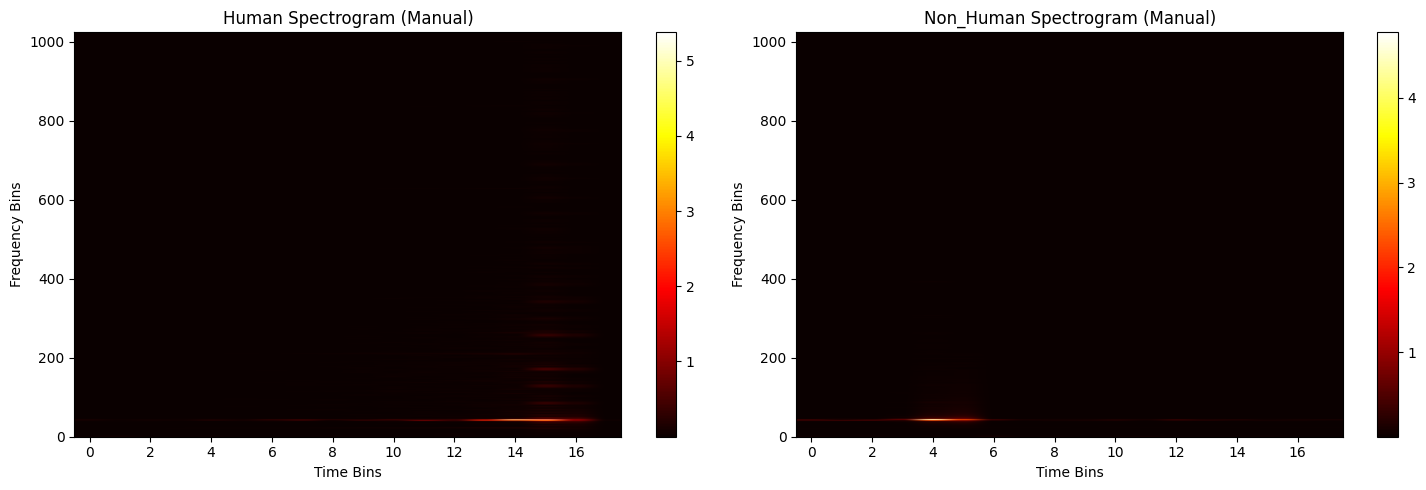


Diagnostic analysis complete!


In [20]:
# Cell 13: Check raw signal from CSV files

print("\n" + "="*70)
print("RAW SIGNAL ANALYSIS")
print("="*70)

# Read one file from each class
human_file = files_by_class['Human'][0]
non_human_file = files_by_class['Non_Human'][0]

print(f"\nReading raw data:")
print(f"  Human file: {human_file.name}")
print(f"  Non_Human file: {non_human_file.name}")

# Read first row from each
df_human = pd.read_csv(human_file, header=None, nrows=1)
df_non_human = pd.read_csv(non_human_file, header=None, nrows=1)

# Skip metadata
signal_human = df_human.iloc[0, SKIP_FIRST_COLS:].to_numpy(dtype=np.float32)
signal_non_human = df_non_human.iloc[0, SKIP_FIRST_COLS:].to_numpy(dtype=np.float32)

print(f"\nRaw signal statistics:")
print(f"\nHuman signal:")
print(f"  Length: {len(signal_human)}")
print(f"  Min: {signal_human.min():.6f}")
print(f"  Max: {signal_human.max():.6f}")
print(f"  Mean: {signal_human.mean():.6f}")
print(f"  Std: {signal_human.std():.6f}")
print(f"  First 10 values: {signal_human[:10]}")

print(f"\nNon_Human signal:")
print(f"  Length: {len(signal_non_human)}")
print(f"  Min: {signal_non_human.min():.6f}")
print(f"  Max: {signal_non_human.max():.6f}")
print(f"  Mean: {signal_non_human.mean():.6f}")
print(f"  Std: {signal_non_human.std():.6f}")
print(f"  First 10 values: {signal_non_human[:10]}")

# Check if raw signals are identical
are_identical = np.array_equal(signal_human, signal_non_human)
print(f"\nRaw signals identical: {are_identical}")

if are_identical:
    print("ERROR: Raw signals are IDENTICAL!")
    print("Problem is in the CSV data itself!")
else:
    print("Good: Raw signals are DIFFERENT")
    
# Visualize raw signals
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(signal_human[:5000])
axes[0].set_title('Human Raw Signal (first 5000 samples)')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

axes[1].plot(signal_non_human[:5000])
axes[1].set_title('Non_Human Raw Signal (first 5000 samples)')
axes[1].set_xlabel('Sample')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

signal_path = SPECTRO_DIR / "raw_signals.png"
plt.savefig(signal_path, dpi=150, bbox_inches='tight')
print(f"\nRaw signal visualization saved: {signal_path}")

plt.show()

# Compute spectrograms manually to verify
print(f"\n" + "="*70)
print("MANUAL SPECTROGRAM COMPUTATION")
print("="*70)

spec_human = row_to_spectrogram(signal_human)
spec_non_human = row_to_spectrogram(signal_non_human)

print(f"\nManually computed spectrograms:")
print(f"  Human: shape={spec_human.shape}, min={spec_human.min():.6f}, max={spec_human.max():.6f}")
print(f"  Non_Human: shape={spec_non_human.shape}, min={spec_non_human.min():.6f}, max={spec_non_human.max():.6f}")

# Visualize manually computed spectrograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

im1 = axes[0].imshow(spec_human, aspect='auto', origin='lower', cmap='hot')
axes[0].set_title('Human Spectrogram (Manual)')
axes[0].set_xlabel('Time Bins')
axes[0].set_ylabel('Frequency Bins')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(spec_non_human, aspect='auto', origin='lower', cmap='hot')
axes[1].set_title('Non_Human Spectrogram (Manual)')
axes[1].set_xlabel('Time Bins')
axes[1].set_ylabel('Frequency Bins')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()

manual_path = SPECTRO_DIR / "manual_spectrograms.png"
plt.savefig(manual_path, dpi=150, bbox_inches='tight')
print(f"\nManual spectrograms saved: {manual_path}")

plt.show()

print("\nDiagnostic analysis complete!")


TESTING DIFFERENT SPECTROGRAM PARAMETERS

Mode: magnitude
  Human: min=1.673382e-05, max=5.375525e+00, mean=1.344233e-02
  Non_Human: min=3.896694e-06, max=4.773252e+00, mean=5.572047e-03

Mode: psd
  Human: min=5.600415e-10, max=5.779254e+01, mean=1.484381e-02
  Non_Human: min=3.036844e-11, max=4.556786e+01, mean=8.604240e-03

Mode: angle
  Human: min=-3.141568e+00, max=3.141593e+00, mean=1.130925e-03
  Non_Human: min=-3.141095e+00, max=3.141593e+00, mean=-1.893741e-02

Different modes visualization saved: /Volumes/Works/Individual_Project/spectrogram-files-14-11-2025/different_modes.png


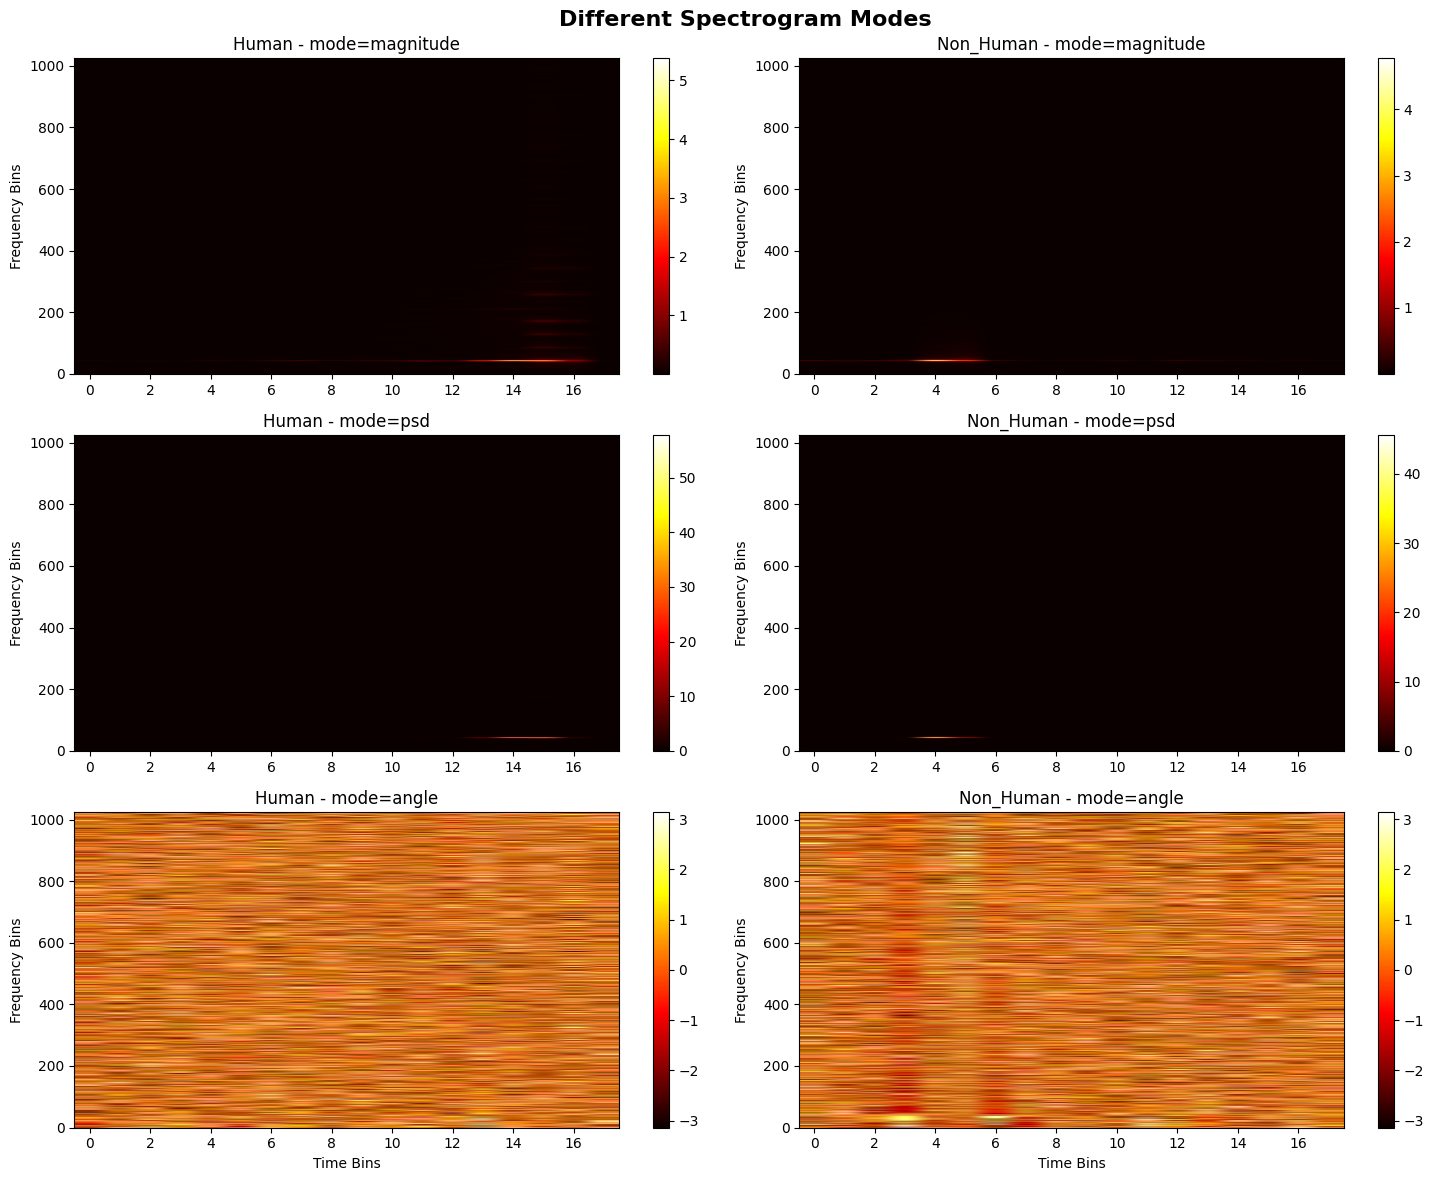

In [21]:
# Cell 14: Test different spectrogram parameters

print("\n" + "="*70)
print("TESTING DIFFERENT SPECTROGRAM PARAMETERS")
print("="*70)

# Get one signal from each class
signal_human = df_human.iloc[0, SKIP_FIRST_COLS:].to_numpy(dtype=np.float32)
signal_non_human = df_non_human.iloc[0, SKIP_FIRST_COLS:].to_numpy(dtype=np.float32)

# Test different modes
modes = ['magnitude', 'psd', 'angle']

fig, axes = plt.subplots(len(modes), 2, figsize=(15, 12))
fig.suptitle('Different Spectrogram Modes', fontsize=16, fontweight='bold')

for i, mode in enumerate(modes):
    # Human
    freqs, times, S_h = sp_spectrogram(
        signal_human, fs=FS, window=WINDOW, 
        nperseg=NPERSEG, noverlap=NOVERLAP, mode=mode
    )
    
    # Non_Human
    freqs, times, S_nh = sp_spectrogram(
        signal_non_human, fs=FS, window=WINDOW,
        nperseg=NPERSEG, noverlap=NOVERLAP, mode=mode
    )
    
    # Plot
    im1 = axes[i, 0].imshow(S_h, aspect='auto', origin='lower', cmap='hot')
    axes[i, 0].set_title(f'Human - mode={mode}')
    axes[i, 0].set_ylabel('Frequency Bins')
    plt.colorbar(im1, ax=axes[i, 0])
    
    im2 = axes[i, 1].imshow(S_nh, aspect='auto', origin='lower', cmap='hot')
    axes[i, 1].set_title(f'Non_Human - mode={mode}')
    axes[i, 1].set_ylabel('Frequency Bins')
    plt.colorbar(im2, ax=axes[i, 1])
    
    if i == len(modes) - 1:
        axes[i, 0].set_xlabel('Time Bins')
        axes[i, 1].set_xlabel('Time Bins')
    
    print(f"\nMode: {mode}")
    print(f"  Human: min={S_h.min():.6e}, max={S_h.max():.6e}, mean={S_h.mean():.6e}")
    print(f"  Non_Human: min={S_nh.min():.6e}, max={S_nh.max():.6e}, mean={S_nh.mean():.6e}")

plt.tight_layout()

modes_path = SPECTRO_DIR / "different_modes.png"
plt.savefig(modes_path, dpi=150, bbox_inches='tight')
print(f"\nDifferent modes visualization saved: {modes_path}")

plt.show()